In [1]:
!pip install torchsummary
!pip install torchviz
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install plotly==4.9.0
!pip install tqdm
!pip install graphviz
!add-apt-repository universe
!apt update
!apt-get --assume-yes install graphviz
!pip install scikit-learn

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-smb5wbqr
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-smb5wbqr
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65818 sha256=ed86eaf655916aaef2a566ccdea9860259d1dce4ad96d64f3be548b32951a72d
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_lggtkj/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install -

In [1]:
import subprocess
import urllib
import cv2
import os
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
import json

import torch
import torchvision
from torchsummary import summary 
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
import albumentations.pytorch as AP

from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import classification_report

from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau

from tqdm import tqdm

In [2]:
!unzip -qq "dataset.zip"
!echo "Found `ls -al "train" | wc -l` training images"

replace train/img_000243.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Found 15854 training images


In [5]:
df = pd.read_csv('dataset_info.csv')

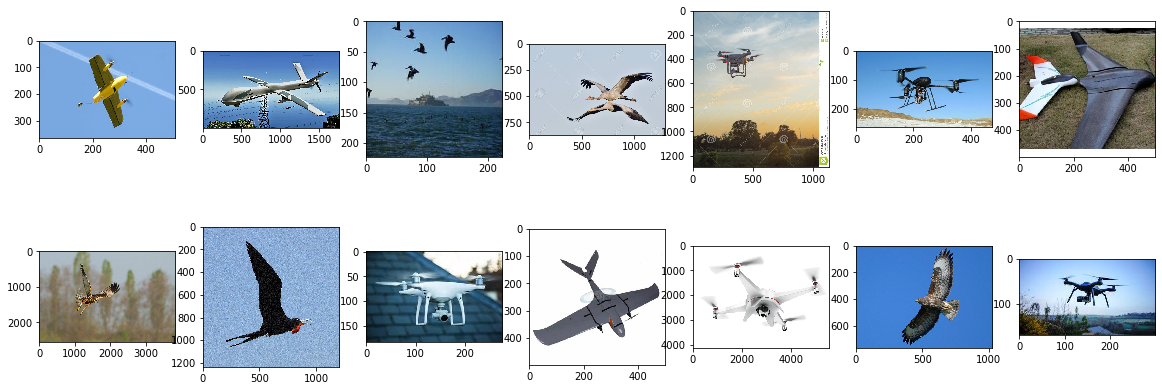

In [6]:
plt.figure(figsize=(20, 7))
for i in range(1, 15):
    plt.subplot(2, 7, i)

    idx = np.random.randint(0, len(df))
    img = cv2.imread(df['train_paths'].iloc[idx], cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    plt.imshow(img)

In [17]:
class FlightDataset(Dataset):
    """
    Custom class to load flight dataset
    """
    def __init__(self, 
               train_transform=None, 
               test_transform=None,
               **kwargs):
        super().__init__(**kwargs)

        self.DATASET_INFO_FILE = 'dataset_info.csv'
        _df = pd.read_csv(self.DATASET_INFO_FILE)
        self.df = _df[_df['valid']].reset_index(drop=True)
        # self.df = self.df[self.df['classes'] != 'Flying Birds'].reset_index(drop=True)

        self.train = True
        self.train_transform = train_transform 
        self.test_transform = test_transform
        self.n_images = len(self.df)

        class_categories = self.df['classes'].astype('category')
        self.df['target'] = class_categories.cat.codes
        self.mapper = dict(enumerate(class_categories.cat.categories))
        w = self.df['classes'].value_counts()
        self.weights = [1] * len(w)
        
        sample_weight = self.df['target'].value_counts()
        # self.weights = np.power(10, 1 - (sample_weight/sample_weight.max()))
        self.weights = np.power(sample_weight, 0)
        self.df['sample_weights'] = self.df['target'].map(self.weights)
        
    def __len__(self):
        return self.n_images
    
    def set_train(self):
        self.train = True
    
    def set_eval(self):
        self.train = False
    
    def __getitem__(self, index):
        img = cv2.imread(self.df['train_paths'].iloc[index], cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        target = self.df['target'].iloc[index]

        if self.train:
            if self.train_transform:
                transform = self.train_transform
        else:
            if self.test_transform:
                transform = self.test_transform

        sample = {}
        # Image augmentation
        transformed = transform(image=img)
        img = transformed['image']

        sample['img'] = img
        sample['target'] = target

        return sample

In [12]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #########################################################################################
        # Mobilenet_v2
        #########################################################################################
        self.mobilenet_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
        # Freezing feature extraction layers
        for param in self.mobilenet_v2.features:
            param.requires_grad = False
        
        # Unfreezing few layers
        for layer_idx in [5, 6, 12, 13, 17, 18]:
            self.mobilenet_v2.features[layer_idx].requires_grad = True

        # _droput = 0.00
        #########################################################################################
        # EXTRA CAPACITY BLOCK
        #########################################################################################

        self.conv_x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), stride=(2, 2), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            # nn.Dropout(_droput)
        )
        
        self.dw_conv_x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), stride=(2, 2), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            # nn.Dropout(_droput)
        )
        
        self.conv_x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=(64 + 64), out_channels=64, kernel_size=(1, 1), stride=(2, 2), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(in_channels=(64), out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            # nn.Dropout(_droput)
        )
        
        self.dw_conv_x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=(64 + 64), out_channels=64, kernel_size=(1, 1), stride=(2, 2), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            # nn.Dropout(_droput)
        )
        
        self.conv_x2_1 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=(1, 1), stride=(2, 2), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            # nn.Dropout(_droput)
        )
        
        self.dw_conv_x2_1 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=(1, 1), stride=(2, 2), bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            # nn.Dropout(_droput)
        )

        self.conv_x3_1 = nn.Sequential(
            nn.Conv2d(in_channels=1280, out_channels=128, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        #########################################################################################
        # GAP LAYER
        #########################################################################################
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        #########################################################################################
        # OUTPUT BLOCK
        #########################################################################################
        self.mixer = nn.Sequential(
            nn.Conv2d(in_channels=(128), out_channels=32, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(32)
            # nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32, out_features=4),
            # nn.Dropout(_droput)
        )

    def blocks(self, x):
        
        x1 = self.mobilenet_v2.features[0:7](x) 
        x2 = self.mobilenet_v2.features[7:14](x1)
        x3 = self.mobilenet_v2.features[14:19](x2)
        
        dw_x1 = self.dw_conv_x1_1(x1)
        x1 = self.conv_x1_1(x1)
        x1 = torch.cat([x1, dw_x1], dim=1)
        
        dw_x1 = self.dw_conv_x1_2(x1)
        x1 = self.conv_x1_2(x1)
        x1 = torch.cat([x1, dw_x1], dim=1)
        
        dw_x2 = self.dw_conv_x2_1(x2)
        x2 = self.conv_x2_1(x2)
        x2 = torch.cat([x2, dw_x2], dim=1)
        
        x3 = self.conv_x3_1(x3)
        x = x1 + x2 + x3
        
        x = self.gap(x)
        x = self.mixer(x)
        x = x.view(-1, 32)

        x1 = self.classifier(x)
        return x1

    def forward(self, x):
        
        x1 = self.blocks(x)
        
        return x1

In [13]:
model = Net()
summary(model, input_size=(3, 224, 224), batch_size=4, device='cpu')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 32, 112, 112]             864
       BatchNorm2d-2          [4, 32, 112, 112]              64
             ReLU6-3          [4, 32, 112, 112]               0
            Conv2d-4          [4, 32, 112, 112]             288
       BatchNorm2d-5          [4, 32, 112, 112]              64
             ReLU6-6          [4, 32, 112, 112]               0
            Conv2d-7          [4, 16, 112, 112]             512
       BatchNorm2d-8          [4, 16, 112, 112]              32
  InvertedResidual-9          [4, 16, 112, 112]               0
           Conv2d-10          [4, 96, 112, 112]           1,536
      BatchNorm2d-11          [4, 96, 112, 112]             192
            ReLU6-12          [4, 96, 112, 112]               0
           Conv2d-13            [4, 96, 56, 56]             864
      BatchNorm2d-14            [4, 96,

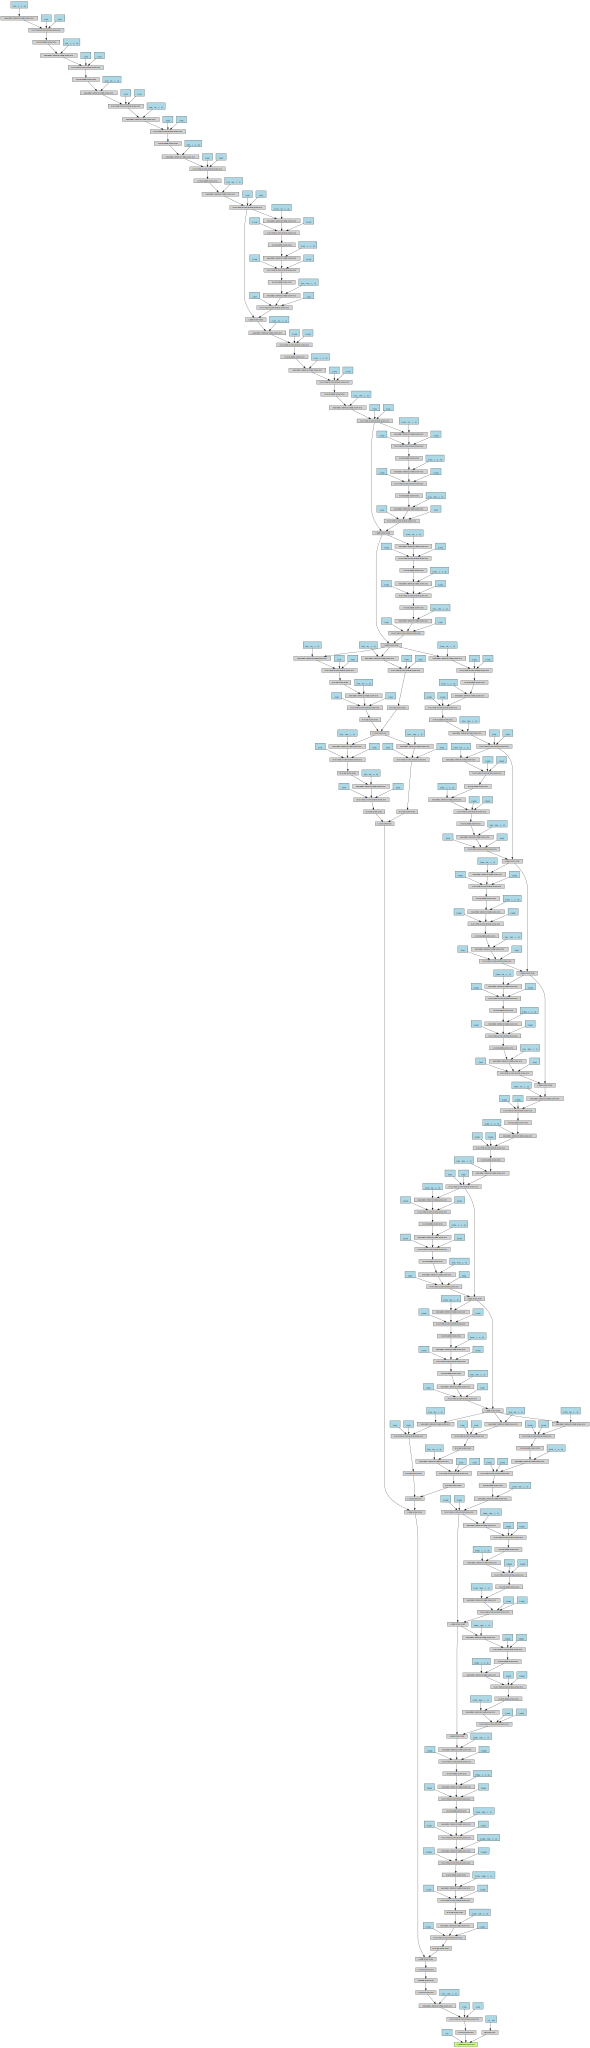

In [8]:
random_input = torch.randn(1, 3, 224, 224)
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph

In [14]:
train_transform = A.Compose(
    [A.PadIfNeeded(min_height=224, min_width=224, p=1.0),
     A.RandomCrop(height=224, width=224, p=1.0),
     A.HorizontalFlip(p=0.5),
     A.Normalize(mean=[0.5276, 0.5793, 0.6078], std=[0.1930, 0.1871, 0.2064],),
     #A.CenterCrop(height=224, width=224, p=1),
     AP.ToTensor()], 
     #A.CenterCrop(height=224, width=224, p=1)],
)

test_transform = A.Compose(
    [A.PadIfNeeded(min_height=224, min_width=224, p=1.0),
     A.Normalize(mean=[0.5276, 0.5793, 0.6078], std=[0.1930, 0.1871, 0.2064],),
     A.CenterCrop(height=224, width=224, p=1),
     AP.ToTensor()],
     #A.HorizontalFlip(p=1)], 
     #A.CenterCrop(height=224, width=224, p=1)]
)

In [18]:
dataset = FlightDataset(train_transform=train_transform, 
                        test_transform=test_transform)

In [20]:
def collate_fn(batch):
    img = [sample['img'] for sample in batch]
    target = [sample['target'] for sample in batch]
    return {'img': img, 'target': target}

In [21]:
sampler = WeightedRandomSampler(weights=dataset.df['sample_weights'].values, num_samples=len(dataset.df), replacement=True)

In [22]:
batch_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    dataloader_args = {'sampler': sampler,
                       'shuffle': False, 
                       'batch_size': batch_size, 
                       'num_workers': 4, 
                       'pin_memory': True, 
                       'collate_fn': collate_fn}
else:
    dataloader_args = {'sampler': sampler,
                       'shuffle': False,
                       'batch_size': batch_size, 
                       'collate_fn': collate_fn}

data_loader = torch.utils.data.DataLoader(dataset, **dataloader_args, drop_last=True)

In [23]:
validation_split = 0.75
train_count = int(validation_split * len(dataset))
validation_count = int((1 - validation_split) * len(dataset))
print(f'Found {train_count} train images, {validation_count} validation images')

Found 11788 train images, 3929 validation images


In [24]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_count + 1, validation_count])

In [25]:
dataset.df['sample_weights'].iloc[train_dataset.indices].value_counts()

1    11789
Name: sample_weights, dtype: int64

In [26]:
train_sampler = WeightedRandomSampler(weights=dataset.df['sample_weights'].iloc[train_dataset.indices].values, 
                                      num_samples=len(train_dataset.indices), 
                                      replacement=False)

In [27]:
if use_cuda:
    train_dataloader_args = {'sampler': train_sampler,
                             'shuffle': False, 
                             'batch_size': batch_size, 
                             'num_workers': 4, 
                             'pin_memory': True, 
                             'collate_fn': collate_fn,
                             'drop_last': True}
else:
    train_dataloader_args = {'sampler': train_sampler,
                             'shuffle': False,
                             'batch_size': batch_size, 
                             'collate_fn': collate_fn,
                             'drop_last': True}

if use_cuda:
    test_dataloader_args = {'shuffle': True, 
                            'batch_size': batch_size, 
                            'num_workers': 4, 
                            'pin_memory': True, 
                            'collate_fn': collate_fn,
                            'drop_last': True}
else:
    test_dataloader_args = {'sampler': sampler,
                            'shuffle': True,
                            'batch_size': batch_size, 
                            'collate_fn': collate_fn,
                            'drop_last': True}

In [28]:
train_dataloader = DataLoader(train_dataset, **train_dataloader_args)
test_dataloader = DataLoader(test_dataset, **test_dataloader_args)

In [29]:
len(train_dataset.indices), len(test_dataset.indices)

(11789, 3929)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 2, 3, 0], dtype=torch.int8)


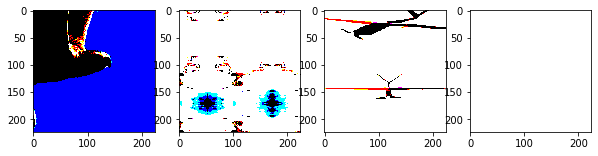

In [30]:
data_iter = iter(train_dataloader)
batch = next(data_iter)
images = batch['img']

print(torch.as_tensor(batch['target']))

plt.figure(figsize=(10, 7))
for i, img in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow((255 * img.permute(1, 2, 0)).round())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 3, 1], dtype=torch.int8)


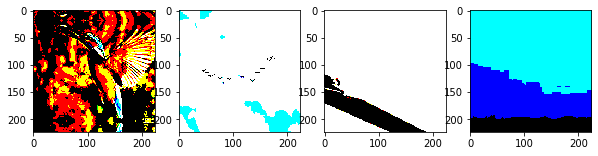

In [31]:
data_iter = iter(test_dataloader)
batch = next(data_iter)
images = batch['img']

print(torch.as_tensor(batch['target']))

plt.figure(figsize=(10, 7))
for i, img in enumerate(images):
    plt.subplot(1, 4, i+1)
    plt.imshow((255 * img.permute(1, 2, 0)).round())

In [ ]:
pbar = tqdm(data_loader)
dataset_len = len(data_loader.dataset)

img_mean = torch.zeros(3).to(device)
img_var = torch.zeros(3).to(device)

for batch_idx, sample_batch in enumerate(pbar):
    images = sample_batch['img']
    for image in images:
        img_mean += image.mean([1, 2])
        img_var += image.std([1, 2]) ** 2

In [ ]:
(img_mean / dataset_len), (torch.sqrt(img_var / dataset_len))

(tensor([0.5276, 0.5793, 0.6078]), tensor([0.1930, 0.1871, 0.2064]))

In [32]:
def train(model, device, train_loader, optimizer, epoch, logs, scheduler=None):
    model.train()
    dataset.set_train()
    train_loss = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    n_train_batches = train_len / batch_size

    train_loss, acc = 0, 0

    y_target = []
    y_pred = []

    log = {}
    log['epoch'] = epoch
    log['batch_loss'] = []

    #if len(logs['train']) > 0:
    #    w = np.array([1 - logs['train'][-1]['report'][str(i)]['f1-score'] for i  in range(4)]) * dataset.weights
    #else:
    w = np.array(dataset.weights)

    log['class_weights'] = w.tolist()

    print('\n')
    print(f"{'Weights:':20s}{w}")
    weights = torch.from_numpy(w).float()
    weights = weights.to(device)

    print('\n')
    for batch_idx, batch in enumerate(pbar):
        images = batch['img']
        target = batch['target']

        y_target.extend(target)

        images = torch.stack(images)
        target = torch.as_tensor(target).long()

        # Move data to cpu/gpu based on input
        images = images.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Loss computation
        batch_loss = F.cross_entropy(output, target, weight=weights, reduction='mean')
        train_loss += (batch_loss / n_train_batches).item()

        # Backward pass)
        batch_loss.backward()

        # Gradient descent
        optimizer.step()

        # Predictions
        output = F.log_softmax(output, dim=-1)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred.extend(pred.detach().cpu().tolist())
        acc += (pred.eq(target.view_as(pred)).float().mean().item() / n_train_batches)

        # Step scheduler if scheduler is present
        if scheduler:
            scheduler.step()

        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TRAIN : epoch={epoch} acc: {100 * acc:.2f} loss: {train_loss:.5f}')
        log['batch_loss'].append(batch_loss.item())

    print('\n')
    report = classification_report(y_target, y_pred, zero_division=0, output_dict=True)
    for item in report:
        print(f'{(dataset.mapper[int(item)] if item in [str(key) for key in dataset.mapper.keys()] else item):20s} : {report[item]}')
    
    log['train_loss'] = train_loss
    log['report'] = report

    logs['train'].append(log)
    return train_loss, acc

In [33]:
def test(model, device, test_loader, epoch, logs):

    model.eval()
    dataset.set_eval()
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    n_test_batches = test_len / batch_size

    test_loss, acc = 0, 0

    y_target = []
    y_pred = []

    log = {}
    log['epoch'] = epoch
    log['batch_loss'] = []

    weights = torch.from_numpy(np.array(dataset.weights)).float()
    weights = weights.to(device)
    
    sample_input_cpu = torch.randn(4, 3, 224, 224).to('cpu')

    print('\n')
    for batch_idx, batch in enumerate(pbar):

        images = batch['img']
        target = batch['target']

        y_target.extend(target)
        
        images = torch.stack(images)
        target = torch.as_tensor(target).long()

        # Move data to cpu/gpu based on input
        images = images.to(device)
        target = target.to(device)

        # Forward pass
        # Forward pass
        output = model(images)

        # Loss computation
        batch_loss = F.cross_entropy(output, target, weight=weights, reduction='mean')
        test_loss += (batch_loss / n_test_batches).item()
        
        # Predictions
        output = F.log_softmax(output, dim=-1)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred.extend(pred.detach().cpu().tolist())
        acc += (pred.eq(target.view_as(pred)).float().mean().item() / n_test_batches)
        
        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TEST : epoch={epoch} acc: {100 * acc:.2f} loss: {test_loss:.5f}')
        log['batch_loss'].append(batch_loss.item())

    print('\n')
    report = classification_report(y_target, y_pred, zero_division=0, output_dict=True)
    for item in report:
        print(f'{(dataset.mapper[int(item)] if item in [str(key) for key in dataset.mapper.keys()] else item):20s} : {report[item]}')
    
    log['test_loss'] = test_loss
    log['report'] = report

    logs['test'].append(log)
    return test_loss, acc

In [120]:
model = Net()
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [121]:
experiment_name = 'flight_mobilenet'

In [122]:
!rm -rf "log_flight_mobilenet"
!rm -rf "model_flight_mobilenet"
!mkdir "log_flight_mobilenet"
!mkdir "model_flight_mobilenet"

In [123]:
tqdm._instances.clear()

In [124]:
sample_input_cpu = torch.randn(4, 3, 224, 224).to('cpu')

In [125]:
best_model_path

'model_flight_mobilenet/acc_0.67_epoch_0.pth'

In [ ]:
now = datetime.datetime.now()

log_file = f'log_{experiment_name}/log_{experiment_name}.json'

lr = 1e-2
epochs = 45
momentum = 0.7

# optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=1500)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

best_test_accuracy = 0
best_test_loss = float('inf')
best_model_path = ''

logs = {}
logs['train'] = []
logs['test'] = []

sample_input_cpu = torch.randn(4, 3, 224, 224).to('cpu')

for epoch in range(0, epochs):
    
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch, logs, scheduler=None)
    test_loss, test_accuracy = test(model, device, test_dataloader, epoch, logs)
    

    if test_accuracy > best_test_accuracy:
        best_model_path = f'{model_dir_suffix}/acc_{test_accuracy:2.2f}_epoch_{epoch}.pth'
        
        model_cpu = model.to('cpu')
        model_cpu = torch.jit.trace(model_cpu, sample_input_cpu)
        torch.jit.save(model_cpu, best_model_path)
        
        best_test_accuracy = test_accuracy 
        best_test_loss = test_loss
        
        model = model.to(device)
    with open(log_file, 'w') as outfile:
        json.dump(logs, outfile)
    
    scheduler.step()

  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.6198172874209417, 'recall': 0.7691301504251145, 'f1-score': 0.686448098064014, 'support': 4587}
Large QuadCopters    : {'precision': 0.41511541325390916, 'recall': 0.3801568360040914, 'f1-score': 0.396867770065848, 'support': 2933}
Small QuadCopters    : {'precision': 0.4879518072289157, 'recall': 0.41422594142259417, 'f1-score': 0.4480764395272819, 'support': 2151}
Winged Drones        : {'precision': 0.4217171717171717, 'recall': 0.31554085970713275, 'f1-score': 0.36098351796811673, 'support': 2117}
accuracy             : 0.5261282660332541
macro avg            : {'precision': 0.48615041990523455, 'recall': 0.4697634468897332, 'f1-score': 0.47309395640631513, 'support': 11788}
weighted avg         : {'precision': 0.5092462669111152, 'recall': 0.5261282660332541, 'f1-score': 0.512450383812729, 'support': 11788}




TEST : epoch=0 acc: 75.16 loss: 0.69729: 100%|██████████| 982/982 [01:04<00:00, 15.24it/s]




Flying Birds         : {'precision': 0.8420138888888888, 'recall': 0.9466493168510085, 'f1-score': 0.891271056661562, 'support': 1537}
Large QuadCopters    : {'precision': 0.6709346991037132, 'recall': 0.5390946502057613, 'f1-score': 0.5978322875071306, 'support': 972}
Small QuadCopters    : {'precision': 0.6558139534883721, 'recall': 0.7652645861601085, 'f1-score': 0.7063243581715718, 'support': 737}
Winged Drones        : {'precision': 0.7334525939177102, 'recall': 0.6011730205278593, 'f1-score': 0.660757453666398, 'support': 682}
accuracy             : 0.7517820773930753
macro avg            : {'precision': 0.7255537838496711, 'recall': 0.7130453934361843, 'f1-score': 0.7140462890016657, 'support': 3928}
weighted avg         : {'precision': 0.7458944571089205, 'recall': 0.7517820773930753, 'f1-score': 0.7439343770159581, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.6747336102582626, 'recall': 0.8146532926297427, 'f1-score': 0.7381211103427838, 'support': 4586}
Large QuadCopters    : {'precision': 0.4755700325732899, 'recall': 0.44785276073619634, 'f1-score': 0.4612954186413902, 'support': 2934}
Small QuadCopters    : {'precision': 0.5790340285400659, 'recall': 0.4904695490469549, 'f1-score': 0.5310848225522277, 'support': 2151}
Winged Drones        : {'precision': 0.5090036014405762, 'recall': 0.4005668398677374, 'f1-score': 0.4483214380121596, 'support': 2117}
accuracy             : 0.589837122497455
macro avg            : {'precision': 0.5595853182030487, 'recall': 0.5383856105701579, 'f1-score': 0.5447056973871403, 'support': 11788}
weighted avg         : {'precision': 0.5779363447449786, 'recall': 0.589837122497455, 'f1-score': 0.5793963444101994, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9011627906976745, 'recall': 0.908203125, 'f1-score': 0.9046692607003892, 'support': 1536}
Large QuadCopters    : {'precision': 0.6827880512091038, 'recall': 0.4933196300102775, 'f1-score': 0.5727923627684963, 'support': 973}
Small QuadCopters    : {'precision': 0.5517551755175517, 'recall': 0.8317503392130258, 'f1-score': 0.6634199134199134, 'support': 737}
Winged Drones        : {'precision': 0.7455830388692579, 'recall': 0.6187683284457478, 'f1-score': 0.6762820512820513, 'support': 682}
accuracy             : 0.7408350305498982
macro avg            : {'precision': 0.720322264073397, 'recall': 0.7130103556672628, 'f1-score': 0.7042908970427126, 'support': 3928}
weighted avg         : {'precision': 0.7544984768847646, 'recall': 0.7408350305498982, 'f1-score': 0.7375416977022351, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7010557510650121, 'recall': 0.8251580553738828, 'f1-score': 0.7580612858001202, 'support': 4587}
Large QuadCopters    : {'precision': 0.49877408056042033, 'recall': 0.48534423994546694, 'f1-score': 0.4919675246156504, 'support': 2934}
Small QuadCopters    : {'precision': 0.6042553191489362, 'recall': 0.5281264528126453, 'f1-score': 0.5636318531381791, 'support': 2151}
Winged Drones        : {'precision': 0.5634824667472793, 'recall': 0.44045368620037806, 'f1-score': 0.4944297082228117, 'support': 2116}
accuracy             : 0.6173227010519172
macro avg            : {'precision': 0.591891904380412, 'recall': 0.5697706085830933, 'f1-score': 0.5770225929441903, 'support': 11788}
weighted avg         : {'precision': 0.6083498450649888, 'recall': 0.6173227010519172, 'f1-score': 0.6090299638519819, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8563829787234043, 'recall': 0.943359375, 'f1-score': 0.8977695167286246, 'support': 1536}
Large QuadCopters    : {'precision': 0.5707620528771384, 'recall': 0.7543679342240494, 'f1-score': 0.6498450641876936, 'support': 973}
Small QuadCopters    : {'precision': 0.8015564202334631, 'recall': 0.5590230664857531, 'f1-score': 0.6586730615507594, 'support': 737}
Winged Drones        : {'precision': 0.7912844036697247, 'recall': 0.5058651026392962, 'f1-score': 0.6171735241502683, 'support': 682}
accuracy             : 0.7484725050916496
macro avg            : {'precision': 0.7549964638759327, 'recall': 0.6906538695872747, 'f1-score': 0.7058652916543364, 'support': 3928}
weighted avg         : {'precision': 0.7640424587024996, 'recall': 0.7484725050916496, 'f1-score': 0.7427768877248437, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7165456914200633, 'recall': 0.8393285371702638, 'f1-score': 0.7730923694779117, 'support': 4587}
Large QuadCopters    : {'precision': 0.49913464866735896, 'recall': 0.49147920927062033, 'f1-score': 0.4952773484458183, 'support': 2934}
Small QuadCopters    : {'precision': 0.6451612903225806, 'recall': 0.5395348837209303, 'f1-score': 0.5876393110435664, 'support': 2150}
Winged Drones        : {'precision': 0.5850694444444444, 'recall': 0.47756258856872935, 'f1-score': 0.5258777633289987, 'support': 2117}
accuracy             : 0.6331014591109603
macro avg            : {'precision': 0.6114777687136119, 'recall': 0.586976304682636, 'f1-score': 0.5954716980740737, 'support': 11788}
weighted avg         : {'precision': 0.6258012329331777, 'recall': 0.6331014591109603, 'f1-score': 0.6257232934209679, 'support': 11788}




TEST : epoch=3 acc: 75.95 loss: 0.65818: 100%|██████████| 982/982 [01:03<00:00, 15.44it/s]




Flying Birds         : {'precision': 0.8665469778575703, 'recall': 0.9420949902407287, 'f1-score': 0.9027431421446384, 'support': 1537}
Large QuadCopters    : {'precision': 0.7406199021207178, 'recall': 0.46659815005138744, 'f1-score': 0.5725094577553594, 'support': 973}
Small QuadCopters    : {'precision': 0.725699067909454, 'recall': 0.7404891304347826, 'f1-score': 0.7330195023537324, 'support': 736}
Winged Drones        : {'precision': 0.6013437849944009, 'recall': 0.7873900293255132, 'f1-score': 0.6819047619047619, 'support': 682}
accuracy             : 0.7596741344195519
macro avg            : {'precision': 0.7335524332205358, 'recall': 0.734143075013103, 'f1-score': 0.722544216039623, 'support': 3928}
weighted avg         : {'precision': 0.7629167120870884, 'recall': 0.7596741344195519, 'f1-score': 0.7507966683359645, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7217131101552272, 'recall': 0.8412906038805319, 'f1-score': 0.7769277229716126, 'support': 4587}
Large QuadCopters    : {'precision': 0.5101497504159733, 'recall': 0.5224948875255624, 'f1-score': 0.5162485266879946, 'support': 2934}
Small QuadCopters    : {'precision': 0.6598407281001137, 'recall': 0.5392840539284054, 'f1-score': 0.5935021744691737, 'support': 2151}
Winged Drones        : {'precision': 0.5816448152562574, 'recall': 0.4612476370510397, 'f1-score': 0.514496573537164, 'support': 2116}
accuracy             : 0.6386155412283678
macro avg            : {'precision': 0.618337100981893, 'recall': 0.5910792955963848, 'f1-score': 0.6002937494164862, 'support': 11788}
weighted avg         : {'precision': 0.6326226025812758, 'recall': 0.6386155412283678, 'f1-score': 0.6314674728080416, 'support': 11788}




TEST : epoch=4 acc: 77.55 loss: 0.61199: 100%|██████████| 982/982 [01:03<00:00, 15.42it/s]




Flying Birds         : {'precision': 0.9328010645375915, 'recall': 0.9127604166666666, 'f1-score': 0.9226719315564329, 'support': 1536}
Large QuadCopters    : {'precision': 0.5942367601246106, 'recall': 0.7841726618705036, 'f1-score': 0.6761187416925122, 'support': 973}
Small QuadCopters    : {'precision': 0.840958605664488, 'recall': 0.5237449118046132, 'f1-score': 0.6454849498327758, 'support': 737}
Winged Drones        : {'precision': 0.7272727272727273, 'recall': 0.7272727272727273, 'f1-score': 0.7272727272727273, 'support': 682}
accuracy             : 0.7757128309572301
macro avg            : {'precision': 0.7738172893998543, 'recall': 0.7369876794036276, 'f1-score': 0.742887087588612, 'support': 3928}
weighted avg         : {'precision': 0.796018659650131, 'recall': 0.7757128309572301, 'f1-score': 0.7756644680662552, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7402223926380368, 'recall': 0.841726618705036, 'f1-score': 0.7877180454962767, 'support': 4587}
Large QuadCopters    : {'precision': 0.5295282085120422, 'recall': 0.5472212751449028, 'f1-score': 0.5382293762575452, 'support': 2933}
Small QuadCopters    : {'precision': 0.6700622524052066, 'recall': 0.5504416550441655, 'f1-score': 0.6043899948953548, 'support': 2151}
Winged Drones        : {'precision': 0.5868094701240135, 'recall': 0.49173358526216343, 'f1-score': 0.5350809560524287, 'support': 2117}
accuracy             : 0.6524431625381744
macro avg            : {'precision': 0.6316555809198248, 'recall': 0.607780783539067, 'f1-score': 0.6163545931754013, 'support': 11788}
weighted avg         : {'precision': 0.647445360007858, 'recall': 0.6524431625381744, 'f1-score': 0.646818688347277, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8917237087741132, 'recall': 0.9329427083333334, 'f1-score': 0.9118676423798918, 'support': 1536}
Large QuadCopters    : {'precision': 0.6513002364066194, 'recall': 0.566289825282631, 'f1-score': 0.6058273776800439, 'support': 973}
Small QuadCopters    : {'precision': 0.7251381215469613, 'recall': 0.7123473541383989, 'f1-score': 0.7186858316221766, 'support': 737}
Winged Drones        : {'precision': 0.6844207723035952, 'recall': 0.7536656891495601, 'f1-score': 0.7173761339846476, 'support': 682}
accuracy             : 0.7696028513238289
macro avg            : {'precision': 0.7381457097578222, 'recall': 0.7413113942259808, 'f1-score': 0.73843924641669, 'support': 3928}
weighted avg         : {'precision': 0.7649196815152345, 'recall': 0.7696028513238289, 'f1-score': 0.7660439710950281, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.74364896073903, 'recall': 0.842380640941792, 'f1-score': 0.7899417356639068, 'support': 4587}
Large QuadCopters    : {'precision': 0.5291039895356442, 'recall': 0.5514655760054533, 'f1-score': 0.5400534045393858, 'support': 2934}
Small QuadCopters    : {'precision': 0.6835300730747611, 'recall': 0.5655813953488372, 'f1-score': 0.6189870195978622, 'support': 2150}
Winged Drones        : {'precision': 0.6199430199430199, 'recall': 0.5139348134152102, 'f1-score': 0.5619834710743802, 'support': 2117}
accuracy             : 0.660502205632847
macro avg            : {'precision': 0.6440565108231138, 'recall': 0.6183406064278232, 'f1-score': 0.6277414077188838, 'support': 11788}
weighted avg         : {'precision': 0.6570680283795064, 'recall': 0.660502205632847, 'f1-score': 0.6556261054299936, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8853349426674714, 'recall': 0.9544567338972023, 'f1-score': 0.9185973700688792, 'support': 1537}
Large QuadCopters    : {'precision': 0.7388535031847133, 'recall': 0.47687564234326824, 'f1-score': 0.5796377264209869, 'support': 973}
Small QuadCopters    : {'precision': 0.6931818181818182, 'recall': 0.7449118046132972, 'f1-score': 0.7181164159581427, 'support': 737}
Winged Drones        : {'precision': 0.6204465334900118, 'recall': 0.775330396475771, 'f1-score': 0.689295039164491, 'support': 681}
accuracy             : 0.7657841140529531
macro avg            : {'precision': 0.7344541993810036, 'recall': 0.7378936443323847, 'f1-score': 0.7264116379031249, 'support': 3928}
weighted avg         : {'precision': 0.7670731554952462, 'recall': 0.7657841140529531, 'f1-score': 0.7572641002636602, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7545858273798031, 'recall': 0.8519729670808808, 'f1-score': 0.8003276674175712, 'support': 4587}
Large QuadCopters    : {'precision': 0.5346306068601583, 'recall': 0.5526764405046029, 'f1-score': 0.543503772003353, 'support': 2933}
Small QuadCopters    : {'precision': 0.7147632311977716, 'recall': 0.596466759646676, 'f1-score': 0.6502787633046123, 'support': 2151}
Winged Drones        : {'precision': 0.6099887766554434, 'recall': 0.5134624468587624, 'f1-score': 0.5575788663759939, 'support': 2117}
accuracy             : 0.6700882253138786
macro avg            : {'precision': 0.6534921105232941, 'recall': 0.6286446535227305, 'f1-score': 0.6379222672753826, 'support': 11788}
weighted avg         : {'precision': 0.666623575720901, 'recall': 0.6700882253138786, 'f1-score': 0.6654516163654932, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9558173784977909, 'recall': 0.8445022771633052, 'f1-score': 0.8967184801381693, 'support': 1537}
Large QuadCopters    : {'precision': 0.576271186440678, 'recall': 0.8036998972250771, 'f1-score': 0.671244635193133, 'support': 973}
Small QuadCopters    : {'precision': 0.7748447204968945, 'recall': 0.6770691994572592, 'f1-score': 0.7226647356987691, 'support': 737}
Winged Drones        : {'precision': 0.7539543057996485, 'recall': 0.6299559471365639, 'f1-score': 0.6864, 'support': 681}
accuracy             : 0.7657841140529531
macro avg            : {'precision': 0.7652218978087529, 'recall': 0.7388068302455513, 'f1-score': 0.7442569627575178, 'support': 3928}
weighted avg         : {'precision': 0.7928479166022545, 'recall': 0.7657841140529531, 'f1-score': 0.7717463452712011, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7544333076329992, 'recall': 0.853467073702573, 'f1-score': 0.8009003478616737, 'support': 4586}
Large QuadCopters    : {'precision': 0.5366010964205095, 'recall': 0.567143830947512, 'f1-score': 0.5514498757249379, 'support': 2934}
Small QuadCopters    : {'precision': 0.7052217855137564, 'recall': 0.5839144583914458, 'f1-score': 0.6388606307222787, 'support': 2151}
Winged Drones        : {'precision': 0.6263096623981373, 'recall': 0.5082664147378365, 'f1-score': 0.561147327249022, 'support': 2117}
accuracy             : 0.671021377672209
macro avg            : {'precision': 0.6556414629913506, 'recall': 0.6281979444448418, 'f1-score': 0.6380895453894782, 'support': 11788}
weighted avg         : {'precision': 0.6682260249100488, 'recall': 0.671021377672209, 'f1-score': 0.6661877366084497, 'support': 11788}




TEST : epoch=8 acc: 78.88 loss: 0.62956: 100%|██████████| 982/982 [01:03<00:00, 15.40it/s]




Flying Birds         : {'precision': 0.8515981735159818, 'recall': 0.9713541666666666, 'f1-score': 0.9075425790754258, 'support': 1536}
Large QuadCopters    : {'precision': 0.7009750812567714, 'recall': 0.6649537512846866, 'f1-score': 0.6824894514767933, 'support': 973}
Small QuadCopters    : {'precision': 0.7362784471218207, 'recall': 0.746268656716418, 'f1-score': 0.7412398921832885, 'support': 737}
Winged Drones        : {'precision': 0.8102766798418972, 'recall': 0.6011730205278593, 'f1-score': 0.6902356902356902, 'support': 682}
accuracy             : 0.7889511201629328
macro avg            : {'precision': 0.7747820954341178, 'recall': 0.7459373987989075, 'f1-score': 0.7553769032427995, 'support': 3928}
weighted avg         : {'precision': 0.7854759317118999, 'recall': 0.7889511201629328, 'f1-score': 0.7828620618703153, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7666019417475728, 'recall': 0.8606932635709614, 'f1-score': 0.8109273903666426, 'support': 4587}
Large QuadCopters    : {'precision': 0.5524386356391456, 'recall': 0.5908625980225025, 'f1-score': 0.5710049423393739, 'support': 2933}
Small QuadCopters    : {'precision': 0.7240204429301533, 'recall': 0.592747559274756, 'f1-score': 0.651840490797546, 'support': 2151}
Winged Drones        : {'precision': 0.639080459770115, 'recall': 0.5252716107699575, 'f1-score': 0.5766139486647655, 'support': 2117}
accuracy             : 0.6844248388191381
macro avg            : {'precision': 0.6705353700217467, 'recall': 0.6423937579095444, 'f1-score': 0.652596693042082, 'support': 11788}
weighted avg         : {'precision': 0.6826439541229915, 'recall': 0.6844248388191381, 'f1-score': 0.6801223329251784, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9180645161290323, 'recall': 0.9264322916666666, 'f1-score': 0.9222294232015553, 'support': 1536}
Large QuadCopters    : {'precision': 0.6506378802747792, 'recall': 0.6813977389516958, 'f1-score': 0.6656626506024097, 'support': 973}
Small QuadCopters    : {'precision': 0.6782407407407407, 'recall': 0.7951153324287653, 'f1-score': 0.7320424734540912, 'support': 737}
Winged Drones        : {'precision': 0.8242424242424242, 'recall': 0.5982404692082112, 'f1-score': 0.6932880203908243, 'support': 682}
accuracy             : 0.7841140529531568
macro avg            : {'precision': 0.7677963903467442, 'recall': 0.7502964580638347, 'f1-score': 0.7533056419122202, 'support': 3928}
weighted avg         : {'precision': 0.7905332264615105, 'recall': 0.7841140529531568, 'f1-score': 0.7832413151517161, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7707764338665626, 'recall': 0.8615351068469255, 'f1-score': 0.8136326194398682, 'support': 4586}
Large QuadCopters    : {'precision': 0.5480244137487954, 'recall': 0.5814587593728698, 'f1-score': 0.5642467339176451, 'support': 2934}
Small QuadCopters    : {'precision': 0.7271695972773681, 'recall': 0.5960018596001859, 'f1-score': 0.6550843127235565, 'support': 2151}
Winged Drones        : {'precision': 0.6472564389697648, 'recall': 0.5460557392536608, 'f1-score': 0.5923648475531643, 'support': 2117}
accuracy             : 0.6867153036986766
macro avg            : {'precision': 0.6733067209656227, 'recall': 0.6462628662684106, 'f1-score': 0.6563321284085586, 'support': 11788}
weighted avg         : {'precision': 0.6851940991426564, 'recall': 0.6867153036986766, 'f1-score': 0.6828929291655943, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8765432098765432, 'recall': 0.9244791666666666, 'f1-score': 0.899873257287706, 'support': 1536}
Large QuadCopters    : {'precision': 0.6722338204592901, 'recall': 0.6618705035971223, 'f1-score': 0.6670119109269809, 'support': 973}
Small QuadCopters    : {'precision': 0.8298755186721992, 'recall': 0.5427408412483039, 'f1-score': 0.6562756357670222, 'support': 737}
Winged Drones        : {'precision': 0.6094470046082949, 'recall': 0.7756598240469208, 'f1-score': 0.6825806451612904, 'support': 682}
accuracy             : 0.7619653767820774
macro avg            : {'precision': 0.7470248884040819, 'recall': 0.7261875838897534, 'f1-score': 0.7264353622857498, 'support': 3928}
weighted avg         : {'precision': 0.7708032057234032, 'recall': 0.7619653767820774, 'f1-score': 0.758758415500551, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7754063050714706, 'recall': 0.8633093525179856, 'f1-score': 0.8170002063131834, 'support': 4587}
Large QuadCopters    : {'precision': 0.5538461538461539, 'recall': 0.588957055214724, 'f1-score': 0.5708622398414273, 'support': 2934}
Small QuadCopters    : {'precision': 0.7191392978482446, 'recall': 0.5906976744186047, 'f1-score': 0.6486210418794689, 'support': 2150}
Winged Drones        : {'precision': 0.6373259052924791, 'recall': 0.5403873405762872, 'f1-score': 0.5848670756646217, 'support': 2117}
accuracy             : 0.6873091279267052
macro avg            : {'precision': 0.671429415514587, 'recall': 0.6458378556819003, 'f1-score': 0.6553376409246753, 'support': 11788}
weighted avg         : {'precision': 0.685200353632962, 'recall': 0.6873091279267052, 'f1-score': 0.6833380214859334, 'support': 11788}




TEST : epoch=11 acc: 80.76 loss: 0.57438: 100%|██████████| 982/982 [01:05<00:00, 14.89it/s]




Flying Birds         : {'precision': 0.8943236714975845, 'recall': 0.9635653871177619, 'f1-score': 0.9276542436580018, 'support': 1537}
Large QuadCopters    : {'precision': 0.716304347826087, 'recall': 0.6779835390946503, 'f1-score': 0.69661733615222, 'support': 972}
Small QuadCopters    : {'precision': 0.794162826420891, 'recall': 0.7014925373134329, 'f1-score': 0.744956772334294, 'support': 737}
Winged Drones        : {'precision': 0.7360912981455064, 'recall': 0.7565982404692082, 'f1-score': 0.7462039045553146, 'support': 682}
accuracy             : 0.8077902240325866
macro avg            : {'precision': 0.7852205359725173, 'recall': 0.7749099259987633, 'f1-score': 0.7788580641749576, 'support': 3928}
weighted avg         : {'precision': 0.8040060024404726, 'recall': 0.8077902240325866, 'f1-score': 0.8046998032992377, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7768223568497167, 'recall': 0.8667684256432621, 'f1-score': 0.819334226527878, 'support': 4586}
Large QuadCopters    : {'precision': 0.5564568462037638, 'recall': 0.5845262440354465, 'f1-score': 0.5701462765957448, 'support': 2934}
Small QuadCopters    : {'precision': 0.7414492753623189, 'recall': 0.594607159460716, 'f1-score': 0.6599587203302374, 'support': 2151}
Winged Drones        : {'precision': 0.6437768240343348, 'recall': 0.5668398677373642, 'f1-score': 0.6028636021100225, 'support': 2117}
accuracy             : 0.6929928741092637
macro avg            : {'precision': 0.6796263256125336, 'recall': 0.6531854242191971, 'f1-score': 0.6630757063909707, 'support': 11788}
weighted avg         : {'precision': 0.6916257756243365, 'recall': 0.6929928741092637, 'f1-score': 0.6893543766106229, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.913510101010101, 'recall': 0.9414443721535458, 'f1-score': 0.9272669016340916, 'support': 1537}
Large QuadCopters    : {'precision': 0.6443691786621507, 'recall': 0.7829218106995884, 'f1-score': 0.7069205759405481, 'support': 972}
Small QuadCopters    : {'precision': 0.8407407407407408, 'recall': 0.6160108548168249, 'f1-score': 0.7110415035238841, 'support': 737}
Winged Drones        : {'precision': 0.7865168539325843, 'recall': 0.718475073313783, 'f1-score': 0.7509578544061303, 'support': 682}
accuracy             : 0.8024439918533605
macro avg            : {'precision': 0.7962842185863942, 'recall': 0.7647130277459355, 'f1-score': 0.7740467088761636, 'support': 3928}
weighted avg         : {'precision': 0.8112073032637689, 'recall': 0.8024439918533605, 'f1-score': 0.8015597944062869, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7847877358490566, 'recall': 0.8705035971223022, 'f1-score': 0.8254263565891473, 'support': 4587}
Large QuadCopters    : {'precision': 0.5565134099616859, 'recall': 0.5940695296523517, 'f1-score': 0.5746785361028685, 'support': 2934}
Small QuadCopters    : {'precision': 0.7378917378917379, 'recall': 0.6023255813953489, 'f1-score': 0.6632522407170295, 'support': 2150}
Winged Drones        : {'precision': 0.6563706563706564, 'recall': 0.5621162021728862, 'f1-score': 0.6055979643765904, 'support': 2117}
accuracy             : 0.6974041398031897
macro avg            : {'precision': 0.6838908850182842, 'recall': 0.6572537275857222, 'f1-score': 0.6672387744464089, 'support': 11788}
weighted avg         : {'precision': 0.6963552430582902, 'recall': 0.6974041398031897, 'f1-score': 0.6939583246290373, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9458054936896808, 'recall': 0.8288874430709173, 'f1-score': 0.883495145631068, 'support': 1537}
Large QuadCopters    : {'precision': 0.618421052631579, 'recall': 0.6762589928057554, 'f1-score': 0.6460481099656358, 'support': 973}
Small QuadCopters    : {'precision': 0.7698986975397974, 'recall': 0.7218453188602443, 'f1-score': 0.7450980392156863, 'support': 737}
Winged Drones        : {'precision': 0.6428571428571429, 'recall': 0.7797356828193832, 'f1-score': 0.7047113470471136, 'support': 681}
accuracy             : 0.7624745417515275
macro avg            : {'precision': 0.74424559667955, 'recall': 0.7516818593890752, 'f1-score': 0.7448381604648759, 'support': 3928}
weighted avg         : {'precision': 0.7791822256578694, 'recall': 0.7624745417515275, 'f1-score': 0.767714493908493, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.7938185443668992, 'recall': 0.8678875081752779, 'f1-score': 0.8292022495313477, 'support': 4587}
Large QuadCopters    : {'precision': 0.5515923566878981, 'recall': 0.5905216501875213, 'f1-score': 0.5703935452000658, 'support': 2933}
Small QuadCopters    : {'precision': 0.7196675900277009, 'recall': 0.603905160390516, 'f1-score': 0.6567239635995956, 'support': 2151}
Winged Drones        : {'precision': 0.6296498905908097, 'recall': 0.5436939064714218, 'f1-score': 0.5835234474017744, 'support': 2117}
accuracy             : 0.6924838819138106
macro avg            : {'precision': 0.6736820954183269, 'recall': 0.6515020563061843, 'f1-score': 0.6599608014331958, 'support': 11788}
weighted avg         : {'precision': 0.690536125696208, 'recall': 0.6924838819138106, 'f1-score': 0.6892133839942629, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.912532637075718, 'recall': 0.91015625, 'f1-score': 0.9113428943937417, 'support': 1536}
Large QuadCopters    : {'precision': 0.7343173431734318, 'recall': 0.6135662898252826, 'f1-score': 0.6685330347144457, 'support': 973}
Small QuadCopters    : {'precision': 0.7591339648173207, 'recall': 0.7611940298507462, 'f1-score': 0.7601626016260161, 'support': 737}
Winged Drones        : {'precision': 0.6445497630331753, 'recall': 0.7976539589442815, 'f1-score': 0.7129750982961992, 'support': 682}
accuracy             : 0.7892057026476579
macro avg            : {'precision': 0.7626334270249114, 'recall': 0.7706426321550777, 'f1-score': 0.7632534072576007, 'support': 3928}
weighted avg         : {'precision': 0.7930767759457847, 'recall': 0.7892057026476579, 'f1-score': 0.7883895577908159, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.819620253164557, 'recall': 0.9036197121674662, 'f1-score': 0.8595727027587639, 'support': 4586}
Large QuadCopters    : {'precision': 0.5922150139017609, 'recall': 0.6533742331288344, 'f1-score': 0.6212931453573164, 'support': 2934}
Small QuadCopters    : {'precision': 0.7844276583381755, 'recall': 0.6276150627615062, 'f1-score': 0.6973140495867768, 'support': 2151}
Winged Drones        : {'precision': 0.709695603156708, 'recall': 0.5947094945677845, 'f1-score': 0.6471344127473657, 'support': 2117}
accuracy             : 0.7354937224295894
macro avg            : {'precision': 0.7264896321403004, 'recall': 0.6948296256563978, 'f1-score': 0.7063285776125556, 'support': 11788}
weighted avg         : {'precision': 0.7368567031530872, 'recall': 0.7354937224295894, 'f1-score': 0.7325059870866464, 'support': 11788}




TEST : epoch=15 acc: 82.54 loss: 0.53677: 100%|██████████| 982/982 [01:05<00:00, 14.95it/s]




Flying Birds         : {'precision': 0.940241576605213, 'recall': 0.9622641509433962, 'f1-score': 0.9511254019292604, 'support': 1537}
Large QuadCopters    : {'precision': 0.7335490830636462, 'recall': 0.6995884773662552, 'f1-score': 0.7161664033701949, 'support': 972}
Small QuadCopters    : {'precision': 0.8207547169811321, 'recall': 0.7082767978290366, 'f1-score': 0.7603787327021122, 'support': 737}
Winged Drones        : {'precision': 0.7095959595959596, 'recall': 0.8240469208211144, 'f1-score': 0.762550881953867, 'support': 682}
accuracy             : 0.8256109979633401
macro avg            : {'precision': 0.8010353340614877, 'recall': 0.7985440867399507, 'f1-score': 0.7975553549888585, 'support': 3928}
weighted avg         : {'precision': 0.826629756323731, 'recall': 0.8256109979633401, 'f1-score': 0.8244532368470207, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8397085610200364, 'recall': 0.9045127534336167, 'f1-score': 0.8709068010075567, 'support': 4587}
Large QuadCopters    : {'precision': 0.6054931335830213, 'recall': 0.6612133605998637, 'f1-score': 0.6321277289019225, 'support': 2934}
Small QuadCopters    : {'precision': 0.786281179138322, 'recall': 0.6448163644816365, 'f1-score': 0.7085568326947637, 'support': 2151}
Winged Drones        : {'precision': 0.7120808940926024, 'recall': 0.6323251417769377, 'f1-score': 0.669837296620776, 'support': 2116}
accuracy             : 0.7477095351204615
macro avg            : {'precision': 0.7358909419584955, 'recall': 0.7107169050730135, 'f1-score': 0.7203571648062548, 'support': 11788}
weighted avg         : {'precision': 0.7487541577500822, 'recall': 0.7477095351204615, 'f1-score': 0.7457578655917798, 'support': 11788}




TEST : epoch=16 acc: 83.63 loss: 0.52933: 100%|██████████| 982/982 [01:05<00:00, 14.90it/s]




Flying Birds         : {'precision': 0.9572649572649573, 'recall': 0.9472999349381913, 'f1-score': 0.9522563767168084, 'support': 1537}
Large QuadCopters    : {'precision': 0.7039777983348752, 'recall': 0.7821171634121274, 'f1-score': 0.7409931840311588, 'support': 973}
Small QuadCopters    : {'precision': 0.7982456140350878, 'recall': 0.7418478260869565, 'f1-score': 0.7690140845070423, 'support': 736}
Winged Drones        : {'precision': 0.8146417445482866, 'recall': 0.7668621700879765, 'f1-score': 0.7900302114803625, 'support': 682}
accuracy             : 0.8365580448065173
macro avg            : {'precision': 0.8185325285458017, 'recall': 0.809531773631313, 'f1-score': 0.813073464183843, 'support': 3928}
weighted avg         : {'precision': 0.8399646330977162, 'recall': 0.8365580448065173, 'f1-score': 0.8374234698326992, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8365228013029316, 'recall': 0.8959877889228085, 'f1-score': 0.8652347862707938, 'support': 4586}
Large QuadCopters    : {'precision': 0.5920444033302498, 'recall': 0.65439672801636, 'f1-score': 0.6216610004856726, 'support': 2934}
Small QuadCopters    : {'precision': 0.781038374717833, 'recall': 0.6434216643421664, 'f1-score': 0.7055824624012236, 'support': 2151}
Winged Drones        : {'precision': 0.7152068780225685, 'recall': 0.6287198866320265, 'f1-score': 0.6691804927099045, 'support': 2117}
accuracy             : 0.7417712928401764
macro avg            : {'precision': 0.7312031143433957, 'recall': 0.7056315169783405, 'f1-score': 0.7154146854668986, 'support': 11788}
weighted avg         : {'precision': 0.7437613124311192, 'recall': 0.7417712928401764, 'f1-score': 0.7402683309259183, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9445153061224489, 'recall': 0.9635653871177619, 'f1-score': 0.9539452495974234, 'support': 1537}
Large QuadCopters    : {'precision': 0.6948529411764706, 'recall': 0.7769784172661871, 'f1-score': 0.7336244541484717, 'support': 973}
Small QuadCopters    : {'precision': 0.8361486486486487, 'recall': 0.6716417910447762, 'f1-score': 0.7449209932279911, 'support': 737}
Winged Drones        : {'precision': 0.775, 'recall': 0.7738619676945668, 'f1-score': 0.7744305657604703, 'support': 681}
accuracy             : 0.8296843177189409
macro avg            : {'precision': 0.8126292239868921, 'recall': 0.796511890780823, 'f1-score': 0.8017303156835891, 'support': 3928}
weighted avg         : {'precision': 0.8329502269167424, 'recall': 0.8296843177189409, 'f1-score': 0.8290286226602883, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8395311236863379, 'recall': 0.9056027904948768, 'f1-score': 0.8713162034609334, 'support': 4587}
Large QuadCopters    : {'precision': 0.6055417185554172, 'recall': 0.6629175187457396, 'f1-score': 0.6329319882850634, 'support': 2934}
Small QuadCopters    : {'precision': 0.794151376146789, 'recall': 0.6441860465116279, 'f1-score': 0.7113507960965587, 'support': 2150}
Winged Drones        : {'precision': 0.7213375796178344, 'recall': 0.641946150212565, 'f1-score': 0.6793301674581356, 'support': 2117}
accuracy             : 0.750169664065151
macro avg            : {'precision': 0.7401404495015946, 'recall': 0.7136631264912023, 'f1-score': 0.7237322888251728, 'support': 11788}
weighted avg         : {'precision': 0.751788749690989, 'recall': 0.750169664065151, 'f1-score': 0.7483284742976036, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9439847231063018, 'recall': 0.9654947916666666, 'f1-score': 0.954618603154168, 'support': 1536}
Large QuadCopters    : {'precision': 0.7417582417582418, 'recall': 0.6937307297019527, 'f1-score': 0.7169410515135423, 'support': 973}
Small QuadCopters    : {'precision': 0.7610146862483311, 'recall': 0.7734056987788331, 'f1-score': 0.7671601615074025, 'support': 737}
Winged Drones        : {'precision': 0.7750716332378224, 'recall': 0.7932551319648093, 'f1-score': 0.7840579710144927, 'support': 682}
accuracy             : 0.8322301425661914
macro avg            : {'precision': 0.8054573210876742, 'recall': 0.8064715880280655, 'f1-score': 0.8056944467974013, 'support': 3928}
weighted avg         : {'precision': 0.8302337020252709, 'recall': 0.8322301425661914, 'f1-score': 0.8309578393152542, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8476499189627229, 'recall': 0.9121430128624374, 'f1-score': 0.8787146907487138, 'support': 4587}
Large QuadCopters    : {'precision': 0.6202612296909844, 'recall': 0.66359918200409, 'f1-score': 0.6411987485591965, 'support': 2934}
Small QuadCopters    : {'precision': 0.8003393665158371, 'recall': 0.6578335657833566, 'f1-score': 0.7221229905588161, 'support': 2151}
Winged Drones        : {'precision': 0.7177377892030848, 'recall': 0.6597353497164461, 'f1-score': 0.6875153902979562, 'support': 2116}
accuracy             : 0.7585680352901255
macro avg            : {'precision': 0.7464970760931573, 'recall': 0.7233277775915825, 'f1-score': 0.7323879550411706, 'support': 11788}
weighted avg         : {'precision': 0.7591007605636794, 'recall': 0.7585680352901255, 'f1-score': 0.7567026241346726, 'support': 11788}




TEST : epoch=19 acc: 83.69 loss: 0.49240: 100%|██████████| 982/982 [01:04<00:00, 15.14it/s]




Flying Birds         : {'precision': 0.9612606697307945, 'recall': 0.9525048796356539, 'f1-score': 0.9568627450980391, 'support': 1537}
Large QuadCopters    : {'precision': 0.6966192170818505, 'recall': 0.8047276464542652, 'f1-score': 0.7467811158798282, 'support': 973}
Small QuadCopters    : {'precision': 0.8330605564648118, 'recall': 0.6906377204884667, 'f1-score': 0.7551928783382789, 'support': 737}
Winged Drones        : {'precision': 0.7940298507462686, 'recall': 0.7812041116005873, 'f1-score': 0.7875647668393784, 'support': 681}
accuracy             : 0.8370672097759674
macro avg            : {'precision': 0.8212425735059313, 'recall': 0.8072685895447432, 'f1-score': 0.8116003765388811, 'support': 3928}
weighted avg         : {'precision': 0.8426599048038816, 'recall': 0.8370672097759674, 'f1-score': 0.8376336106211016, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8574081716879901, 'recall': 0.9058207979071289, 'f1-score': 0.8809498568854023, 'support': 4587}
Large QuadCopters    : {'precision': 0.6096320670056835, 'recall': 0.6948516876917832, 'f1-score': 0.6494582536647546, 'support': 2933}
Small QuadCopters    : {'precision': 0.8059191804211725, 'recall': 0.6582984658298466, 'f1-score': 0.7246673490276356, 'support': 2151}
Winged Drones        : {'precision': 0.750814332247557, 'recall': 0.6532829475673122, 'f1-score': 0.6986612781005305, 'support': 2117}
accuracy             : 0.7628096369189006
macro avg            : {'precision': 0.7559434378406008, 'recall': 0.7280634747490177, 'f1-score': 0.7384341844195808, 'support': 11788}
weighted avg         : {'precision': 0.7672199045227776, 'recall': 0.7628096369189006, 'f1-score': 0.762097340094107, 'support': 11788}




TEST : epoch=20 acc: 83.69 loss: 0.55008: 100%|██████████| 982/982 [01:04<00:00, 15.15it/s]




Flying Birds         : {'precision': 0.9629874421678783, 'recall': 0.9479505530253741, 'f1-score': 0.9554098360655738, 'support': 1537}
Large QuadCopters    : {'precision': 0.6946902654867256, 'recall': 0.8076131687242798, 'f1-score': 0.746907706945766, 'support': 972}
Small QuadCopters    : {'precision': 0.7994011976047904, 'recall': 0.7245590230664858, 'f1-score': 0.7601423487544484, 'support': 737}
Winged Drones        : {'precision': 0.8298217179902755, 'recall': 0.750733137829912, 'f1-score': 0.7882986913010008, 'support': 682}
accuracy             : 0.8370672097759674
macro avg            : {'precision': 0.8217251558124175, 'recall': 0.8077139706615128, 'f1-score': 0.8126896457666972, 'support': 3928}
weighted avg         : {'precision': 0.8427820089025522, 'recall': 0.8370672097759674, 'f1-score': 0.8381628889214313, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8511990161918426, 'recall': 0.9053847830826248, 'f1-score': 0.8774561588844284, 'support': 4587}
Large QuadCopters    : {'precision': 0.6174207448445675, 'recall': 0.6839413569723832, 'f1-score': 0.6489809123261081, 'support': 2933}
Small QuadCopters    : {'precision': 0.8028571428571428, 'recall': 0.6531845653184565, 'f1-score': 0.7203281209946166, 'support': 2151}
Winged Drones        : {'precision': 0.7387434554973822, 'recall': 0.6665092111478508, 'f1-score': 0.7007698038241867, 'support': 2117}
accuracy             : 0.761367492365117
macro avg            : {'precision': 0.7525550898477338, 'recall': 0.7272549791303289, 'f1-score': 0.736883749007335, 'support': 11788}
weighted avg         : {'precision': 0.7640151460362039, 'recall': 0.761367492365117, 'f1-score': 0.7602059619622135, 'support': 11788}




TEST : epoch=21 acc: 84.25 loss: 0.52412: 100%|██████████| 982/982 [01:03<00:00, 15.54it/s]




Flying Birds         : {'precision': 0.9430740037950665, 'recall': 0.9700715679895902, 'f1-score': 0.9563822963438101, 'support': 1537}
Large QuadCopters    : {'precision': 0.7337917485265226, 'recall': 0.7685185185185185, 'f1-score': 0.7507537688442211, 'support': 972}
Small QuadCopters    : {'precision': 0.8029850746268656, 'recall': 0.7299864314789688, 'f1-score': 0.7647476901208246, 'support': 737}
Winged Drones        : {'precision': 0.8103186646433991, 'recall': 0.782991202346041, 'f1-score': 0.796420581655481, 'support': 682}
accuracy             : 0.8426680244399185
macro avg            : {'precision': 0.8225423728979634, 'recall': 0.8128919300832795, 'f1-score': 0.8170760842410841, 'support': 3928}
weighted avg         : {'precision': 0.8419520500732168, 'recall': 0.8426680244399185, 'f1-score': 0.8417693831733974, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8549491595766756, 'recall': 0.8981905384783082, 'f1-score': 0.8760365724005953, 'support': 4587}
Large QuadCopters    : {'precision': 0.6206255806751316, 'recall': 0.6832594613024208, 'f1-score': 0.6504381694255112, 'support': 2933}
Small QuadCopters    : {'precision': 0.8062146892655367, 'recall': 0.6634123663412367, 'f1-score': 0.7278755419535834, 'support': 2151}
Winged Drones        : {'precision': 0.7279187817258883, 'recall': 0.6773736419461502, 'f1-score': 0.7017372155615366, 'support': 2117}
accuracy             : 0.762215812690872
macro avg            : {'precision': 0.7524270528108081, 'recall': 0.730559002017029, 'f1-score': 0.7390218748353067, 'support': 11788}
weighted avg         : {'precision': 0.7649404886852942, 'recall': 0.762215812690872, 'f1-score': 0.7615670923492099, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.9593175853018373, 'recall': 0.9518229166666666, 'f1-score': 0.9555555555555556, 'support': 1536}
Large QuadCopters    : {'precision': 0.7456410256410256, 'recall': 0.7471736896197327, 'f1-score': 0.7464065708418891, 'support': 973}
Small QuadCopters    : {'precision': 0.7901408450704225, 'recall': 0.7611940298507462, 'f1-score': 0.7753973738769868, 'support': 737}
Winged Drones        : {'precision': 0.7691237830319889, 'recall': 0.8108504398826979, 'f1-score': 0.7894361170592434, 'support': 682}
accuracy             : 0.8408859470468432
macro avg            : {'precision': 0.8160558097613186, 'recall': 0.8177602690049608, 'f1-score': 0.8166989043334187, 'support': 3928}
weighted avg         : {'precision': 0.8416234093220615, 'recall': 0.8408859470468432, 'f1-score': 0.8411023989674731, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8543531326281529, 'recall': 0.9158307893589185, 'f1-score': 0.8840244159124394, 'support': 4586}
Large QuadCopters    : {'precision': 0.6348208673790069, 'recall': 0.6884798909338786, 'f1-score': 0.6605624591236101, 'support': 2934}
Small QuadCopters    : {'precision': 0.8027700831024931, 'recall': 0.6736401673640168, 'f1-score': 0.7325581395348838, 'support': 2151}
Winged Drones        : {'precision': 0.7511936339522547, 'recall': 0.6688710439300898, 'f1-score': 0.7076461769115443, 'support': 2117}
accuracy             : 0.7706990159484222
macro avg            : {'precision': 0.7607844292654768, 'recall': 0.7367054728967259, 'f1-score': 0.7461977978706194, 'support': 11788}
weighted avg         : {'precision': 0.7717732662837717, 'recall': 0.7706990159484222, 'f1-score': 0.7690910876403456, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.963254593175853, 'recall': 0.9551073519843851, 'f1-score': 0.9591636720026135, 'support': 1537}
Large QuadCopters    : {'precision': 0.6942446043165468, 'recall': 0.7934224049331963, 'f1-score': 0.7405275779376498, 'support': 973}
Small QuadCopters    : {'precision': 0.7939042089985486, 'recall': 0.7421981004070556, 'f1-score': 0.767180925666199, 'support': 737}
Winged Drones        : {'precision': 0.835820895522388, 'recall': 0.7400881057268722, 'f1-score': 0.7850467289719626, 'support': 681}
accuracy             : 0.8378309572301426
macro avg            : {'precision': 0.8218060755033341, 'recall': 0.8077039907628774, 'f1-score': 0.8129797261446062, 'support': 3928}
weighted avg         : {'precision': 0.8427504433793184, 'recall': 0.8378309572301426, 'f1-score': 0.838797622669869, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8502957373036916, 'recall': 0.9088729016786571, 'f1-score': 0.878609062170706, 'support': 4587}
Large QuadCopters    : {'precision': 0.6319851806112998, 'recall': 0.6976823449216087, 'f1-score': 0.6632107565203306, 'support': 2934}
Small QuadCopters    : {'precision': 0.8106274731486716, 'recall': 0.6666666666666666, 'f1-score': 0.7316326530612245, 'support': 2151}
Winged Drones        : {'precision': 0.7469366009589771, 'recall': 0.6625708884688091, 'f1-score': 0.702228900576008, 'support': 2116}
accuracy             : 0.7678995588734306
macro avg            : {'precision': 0.75996124800566, 'recall': 0.7339482004339353, 'f1-score': 0.7439203430820672, 'support': 11788}
weighted avg         : {'precision': 0.7701670011280604, 'recall': 0.7678995588734306, 'f1-score': 0.7665166540686466, 'support': 11788}




  0%|          | 0/2947 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.961463096015676, 'recall': 0.9577098243331165, 'f1-score': 0.9595827900912647, 'support': 1537}
Large QuadCopters    : {'precision': 0.6972076788830716, 'recall': 0.8211716341212744, 'f1-score': 0.7541293062765455, 'support': 973}
Small QuadCopters    : {'precision': 0.8236220472440945, 'recall': 0.7096336499321574, 'f1-score': 0.7623906705539358, 'support': 737}
Winged Drones        : {'precision': 0.8344155844155844, 'recall': 0.7547723935389133, 'f1-score': 0.7925983037779492, 'support': 681}
accuracy             : 0.8421588594704684
macro avg            : {'precision': 0.8291771016396066, 'recall': 0.8108218754813654, 'f1-score': 0.8171752676749238, 'support': 3928}
weighted avg         : {'precision': 0.8481156598613119, 'recall': 0.8421588594704684, 'f1-score': 0.8427413269980616, 'support': 3928}


Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8604076590487956, 'recall': 0.9110529758011773, 'f1-score': 0.8850063532401525, 'support': 4587}
Large QuadCopters    : {'precision': 0.6263803680981596, 'recall': 0.6962154790317081, 'f1-score': 0.6594542225092846, 'support': 2933}
Small QuadCopters    : {'precision': 0.8078212290502793, 'recall': 0.6722454672245467, 'f1-score': 0.7338239025628013, 'support': 2151}
Winged Drones        : {'precision': 0.7623604465709729, 'recall': 0.6773736419461502, 'f1-score': 0.71735867933967, 'support': 2117}
accuracy             : 0.7720563284696301
macro avg            : {'precision': 0.7642424256920518, 'recall': 0.7392218910008956, 'f1-score': 0.7489107894129772, 'support': 11788}
weighted avg         : {'precision': 0.7749748965699549, 'recall': 0.7720563284696301, 'f1-score': 0.7711916283938733, 'support': 11788}




TEST : epoch=25 acc: 84.25 loss: 0.50502: 100%|██████████| 982/982 [01:04<00:00, 15.19it/s]




Flying Birds         : {'precision': 0.9643564356435643, 'recall': 0.951171875, 'f1-score': 0.9577187807276303, 'support': 1536}
Large QuadCopters    : {'precision': 0.7324083250743311, 'recall': 0.7595066803699897, 'f1-score': 0.7457114026236126, 'support': 973}
Small QuadCopters    : {'precision': 0.7771664374140302, 'recall': 0.7666214382632293, 'f1-score': 0.7718579234972677, 'support': 737}
Winged Drones        : {'precision': 0.8050221565731167, 'recall': 0.7991202346041055, 'f1-score': 0.8020603384841796, 'support': 682}
accuracy             : 0.8426680244399185
macro avg            : {'precision': 0.8197383386762606, 'recall': 0.819105057059331, 'f1-score': 0.8193371113331724, 'support': 3928}
weighted avg         : {'precision': 0.8441144502553067, 'recall': 0.8426680244399185, 'f1-score': 0.8433038906349573, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8598304734339467, 'recall': 0.9066928275561369, 'f1-score': 0.8826400679117147, 'support': 4587}
Large QuadCopters    : {'precision': 0.6281017369727047, 'recall': 0.6901840490797546, 'f1-score': 0.6576810652809354, 'support': 2934}
Small QuadCopters    : {'precision': 0.8004484304932735, 'recall': 0.6638772663877266, 'f1-score': 0.7257941550190598, 'support': 2151}
Winged Drones        : {'precision': 0.748327328872877, 'recall': 0.6871455576559546, 'f1-score': 0.7164326188716432, 'support': 2116}
accuracy             : 0.7690872073294877
macro avg            : {'precision': 0.7591769924432006, 'recall': 0.7369749251698932, 'f1-score': 0.7456369767708382, 'support': 11788}
weighted avg         : {'precision': 0.7713028571263546, 'recall': 0.7690872073294877, 'f1-score': 0.7681931528693328, 'support': 11788}




TEST : epoch=26 acc: 84.22 loss: 0.47424: 100%|██████████| 982/982 [01:02<00:00, 15.60it/s]




Flying Birds         : {'precision': 0.9619422572178478, 'recall': 0.9538061158100195, 'f1-score': 0.9578569095066972, 'support': 1537}
Large QuadCopters    : {'precision': 0.7161531279178338, 'recall': 0.7890946502057613, 'f1-score': 0.7508565834557024, 'support': 972}
Small QuadCopters    : {'precision': 0.7890173410404624, 'recall': 0.7408412483039348, 'f1-score': 0.7641707487753673, 'support': 737}
Winged Drones        : {'precision': 0.8268330733229329, 'recall': 0.7771260997067448, 'f1-score': 0.8012093726379439, 'support': 682}
accuracy             : 0.8424134419551935
macro avg            : {'precision': 0.8234864498747692, 'recall': 0.8152170285066151, 'f1-score': 0.8185234035939277, 'support': 3928}
weighted avg         : {'precision': 0.8452169109045385, 'recall': 0.8424134419551935, 'f1-score': 0.8430950364096894, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8604747162022703, 'recall': 0.9090710859136503, 'f1-score': 0.8841056091612766, 'support': 4586}
Large QuadCopters    : {'precision': 0.6364760432766615, 'recall': 0.701772324471711, 'f1-score': 0.6675312044091425, 'support': 2934}
Small QuadCopters    : {'precision': 0.8118249005116543, 'recall': 0.6638772663877266, 'f1-score': 0.7304347826086955, 'support': 2151}
Winged Drones        : {'precision': 0.7516675218060543, 'recall': 0.6920170051960322, 'f1-score': 0.7206099360550909, 'support': 2117}
accuracy             : 0.7737529691211401
macro avg            : {'precision': 0.76511079544916, 'recall': 0.7416844204922799, 'f1-score': 0.7506703830585514, 'support': 11788}
weighted avg         : {'precision': 0.7763041452444284, 'recall': 0.7737529691211401, 'f1-score': 0.7727978732074966, 'support': 11788}




TEST : epoch=27 acc: 83.63 loss: 0.51759: 100%|██████████| 982/982 [01:06<00:00, 14.74it/s]




Flying Birds         : {'precision': 0.9561805101373446, 'recall': 0.9518229166666666, 'f1-score': 0.9539967373572594, 'support': 1536}
Large QuadCopters    : {'precision': 0.723152709359606, 'recall': 0.7543679342240494, 'f1-score': 0.738430583501006, 'support': 973}
Small QuadCopters    : {'precision': 0.7782485875706214, 'recall': 0.7476255088195387, 'f1-score': 0.762629757785467, 'support': 737}
Winged Drones        : {'precision': 0.7973372781065089, 'recall': 0.7903225806451613, 'f1-score': 0.7938144329896907, 'support': 682}
accuracy             : 0.8365580448065173
macro avg            : {'precision': 0.8137297712935203, 'recall': 0.811034735088854, 'f1-score': 0.8122178779083558, 'support': 3928}
weighted avg         : {'precision': 0.8374934018548993, 'recall': 0.8365580448065173, 'f1-score': 0.8368817518111221, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8594235952726519, 'recall': 0.9036407237846087, 'f1-score': 0.8809776833156218, 'support': 4587}
Large QuadCopters    : {'precision': 0.6330645161290323, 'recall': 0.6956373551465576, 'f1-score': 0.6628775576485871, 'support': 2934}
Small QuadCopters    : {'precision': 0.8226164079822617, 'recall': 0.6899116689911668, 'f1-score': 0.7504424778761061, 'support': 2151}
Winged Drones        : {'precision': 0.7573567372225091, 'recall': 0.693289224952741, 'f1-score': 0.7239082161361955, 'support': 2116}
accuracy             : 0.7751102816423482
macro avg            : {'precision': 0.7681153141516137, 'recall': 0.7456197432187686, 'f1-score': 0.7545514837441275, 'support': 11788}
weighted avg         : {'precision': 0.7780456456880648, 'recall': 0.7751102816423482, 'f1-score': 0.774679245229505, 'support': 11788}




TEST : epoch=28 acc: 83.76 loss: 0.48909: 100%|██████████| 982/982 [01:04<00:00, 15.28it/s]




Flying Birds         : {'precision': 0.961437908496732, 'recall': 0.9576822916666666, 'f1-score': 0.9595564253098499, 'support': 1536}
Large QuadCopters    : {'precision': 0.7097378277153558, 'recall': 0.7790339157245632, 'f1-score': 0.7427731504164625, 'support': 973}
Small QuadCopters    : {'precision': 0.8241935483870968, 'recall': 0.6933514246947082, 'f1-score': 0.7531319086219602, 'support': 737}
Winged Drones        : {'precision': 0.776056338028169, 'recall': 0.8079178885630498, 'f1-score': 0.7916666666666667, 'support': 682}
accuracy             : 0.8378309572301426
macro avg            : {'precision': 0.8178564056568384, 'recall': 0.809496380162247, 'f1-score': 0.8117820377537348, 'support': 3928}
weighted avg         : {'precision': 0.841151884295958, 'recall': 0.8378309572301426, 'f1-score': 0.8379765346110486, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8587023686920701, 'recall': 0.9090710859136503, 'f1-score': 0.8831691558097661, 'support': 4586}
Large QuadCopters    : {'precision': 0.6295839753466872, 'recall': 0.696319018404908, 'f1-score': 0.6612720504936074, 'support': 2934}
Small QuadCopters    : {'precision': 0.8120427687113112, 'recall': 0.6708507670850767, 'f1-score': 0.734725050916497, 'support': 2151}
Winged Drones        : {'precision': 0.7592883307169022, 'recall': 0.6854038734057629, 'f1-score': 0.7204568023833168, 'support': 2117}
accuracy             : 0.7724804886325076
macro avg            : {'precision': 0.7649043608667426, 'recall': 0.7404111862023495, 'f1-score': 0.7499057649007967, 'support': 11788}
weighted avg         : {'precision': 0.7753075872170619, 'recall': 0.7724804886325076, 'f1-score': 0.7716310298488885, 'support': 11788}




TEST : epoch=29 acc: 83.91 loss: 0.49929: 100%|██████████| 982/982 [01:04<00:00, 15.21it/s]




Flying Birds         : {'precision': 0.9568576947842885, 'recall': 0.966818477553676, 'f1-score': 0.9618122977346278, 'support': 1537}
Large QuadCopters    : {'precision': 0.7115928369462771, 'recall': 0.7767489711934157, 'f1-score': 0.7427447122479096, 'support': 972}
Small QuadCopters    : {'precision': 0.821256038647343, 'recall': 0.6919945725915875, 'f1-score': 0.7511045655375553, 'support': 737}
Winged Drones        : {'precision': 0.7878787878787878, 'recall': 0.8005865102639296, 'f1-score': 0.7941818181818181, 'support': 682}
accuracy             : 0.8393584521384929
macro avg            : {'precision': 0.8193963395641741, 'recall': 0.8090371329006523, 'f1-score': 0.8124608484254776, 'support': 3928}
weighted avg         : {'precision': 0.8413843045345362, 'recall': 0.8393584521384929, 'f1-score': 0.838963703341209, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8566497461928934, 'recall': 0.9199738334060183, 'f1-score': 0.8871832614866995, 'support': 4586}
Large QuadCopters    : {'precision': 0.6493998736576121, 'recall': 0.7007498295841854, 'f1-score': 0.6740983606557377, 'support': 2934}
Small QuadCopters    : {'precision': 0.8225715889949466, 'recall': 0.6810785681078568, 'f1-score': 0.7451678535096643, 'support': 2151}
Winged Drones        : {'precision': 0.7802713987473904, 'recall': 0.7061880018894662, 'f1-score': 0.7413835854202826, 'support': 2117}
accuracy             : 0.7834238208347472
macro avg            : {'precision': 0.7772231518982107, 'recall': 0.7519975582468816, 'f1-score': 0.7619582652680961, 'support': 11788}
weighted avg         : {'precision': 0.7851307265378689, 'recall': 0.7834238208347472, 'f1-score': 0.782048874327788, 'support': 11788}




TEST : epoch=30 acc: 83.76 loss: 0.51858: 100%|██████████| 982/982 [01:05<00:00, 14.94it/s]




Flying Birds         : {'precision': 0.9490770210057289, 'recall': 0.9700715679895902, 'f1-score': 0.9594594594594595, 'support': 1537}
Large QuadCopters    : {'precision': 0.7425213675213675, 'recall': 0.7142857142857143, 'f1-score': 0.7281299109481403, 'support': 973}
Small QuadCopters    : {'precision': 0.7540106951871658, 'recall': 0.7663043478260869, 'f1-score': 0.7601078167115903, 'support': 736}
Winged Drones        : {'precision': 0.8038632986627043, 'recall': 0.7932551319648093, 'f1-score': 0.7985239852398524, 'support': 682}
accuracy             : 0.8378309572301426
macro avg            : {'precision': 0.8123680955942416, 'recall': 0.8109791905165502, 'f1-score': 0.8115552930897606, 'support': 3928}
weighted avg         : {'precision': 0.8361485013314192, 'recall': 0.8378309572301426, 'f1-score': 0.8368615844131975, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




  0%|          | 0/982 [00:00<?, ?it/s]



Flying Birds         : {'precision': 0.8608215818516247, 'recall': 0.9182472204054938, 'f1-score': 0.8886075949367088, 'support': 4587}
Large QuadCopters    : {'precision': 0.6433697347893915, 'recall': 0.7027948193592365, 'f1-score': 0.6717706466851278, 'support': 2934}
Small QuadCopters    : {'precision': 0.8206253428414702, 'recall': 0.695813953488372, 'f1-score': 0.7530833123584194, 'support': 2150}
Winged Drones        : {'precision': 0.7787895018746652, 'recall': 0.6868209730751063, 'f1-score': 0.7299196787148595, 'support': 2117}
accuracy             : 0.7824906684764167
macro avg            : {'precision': 0.7759015403392878, 'recall': 0.7509192415820521, 'f1-score': 0.7608453081737789, 'support': 11788}
weighted avg         : {'precision': 0.7846349898543693, 'recall': 0.7824906684764167, 'f1-score': 0.7814206987409915, 'support': 11788}




TEST : epoch=31 acc: 84.22 loss: 0.50815: 100%|██████████| 982/982 [01:05<00:00, 15.10it/s]




Flying Birds         : {'precision': 0.9637681159420289, 'recall': 0.9524739583333334, 'f1-score': 0.9580877537655533, 'support': 1536}
Large QuadCopters    : {'precision': 0.706959706959707, 'recall': 0.7934224049331963, 'f1-score': 0.7476997578692494, 'support': 973}
Small QuadCopters    : {'precision': 0.7887931034482759, 'recall': 0.7449118046132972, 'f1-score': 0.7662247034193999, 'support': 737}
Winged Drones        : {'precision': 0.8440514469453376, 'recall': 0.7697947214076246, 'f1-score': 0.8052147239263803, 'support': 682}
accuracy             : 0.8424134419551935
macro avg            : {'precision': 0.8258930933238373, 'recall': 0.8151507223218628, 'f1-score': 0.8193067347451457, 'support': 3928}
weighted avg         : {'precision': 0.8465384992405425, 'recall': 0.8424134419551935, 'f1-score': 0.8434314415296739, 'support': 3928}


  0%|          | 0/2947 [00:00<?, ?it/s]



Weights:            [1 1 1 1]




TRAIN : epoch=32 acc: 51.05 loss: 0.37519:  65%|██████▍   | 1901/2947 [02:08<01:06, 15.76it/s]

In [41]:
best_model = torch.load(best_model_path)

In [162]:
log_file = 'log_flight_mobilenet/log_08-08-20 09:31:00_flight_mobilenet.json'
with open(log_file) as json_file:
    logs = json.load(json_file)

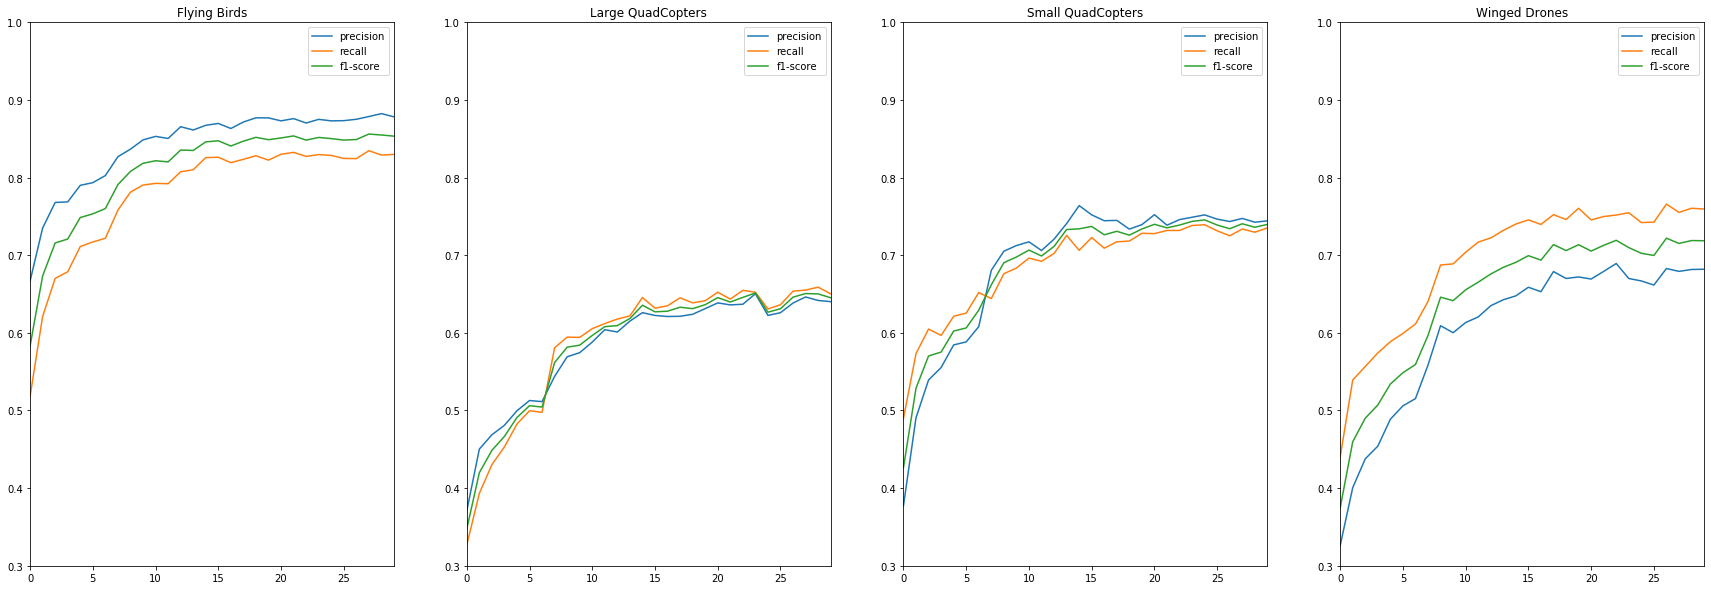

In [163]:
log_df = pd.read_json(log_file)['train'].apply(pd.Series)
dfs = [log_df['report'].apply(pd.Series)[str(cls_idx)].apply(pd.Series) for cls_idx in range(4)]

plt.figure(figsize=(30, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(1, len(dfs), i + 1)
    ax.set_ylim([0.3, 1])
    ax.set_title(dataset.mapper[i])
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

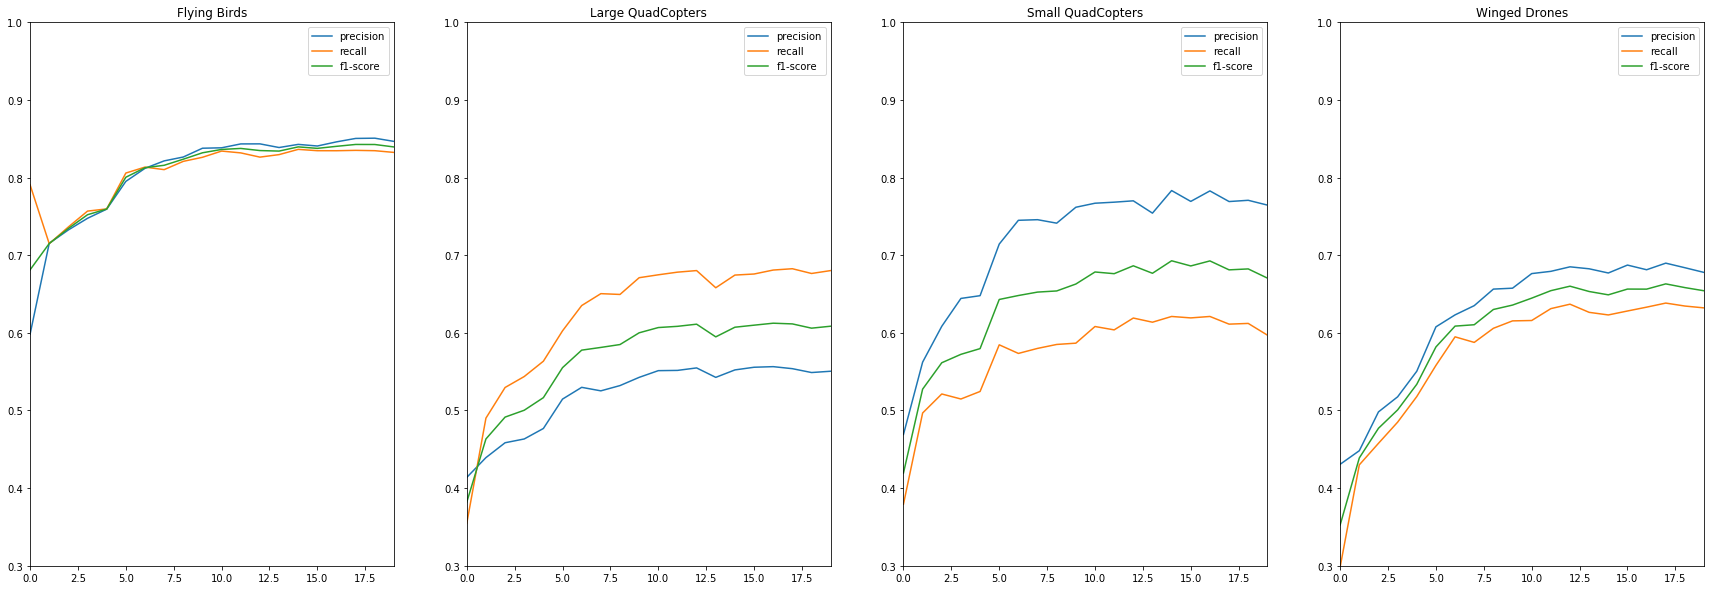

In [36]:
log_df = pd.read_json(log_file)['train'].apply(pd.Series)
dfs = [log_df['report'].apply(pd.Series)[str(cls_idx)].apply(pd.Series) for cls_idx in range(4)]

plt.figure(figsize=(30, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(1, len(dfs), i + 1)
    ax.set_ylim([0.3, 1])
    ax.set_title(dataset.mapper[i])
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

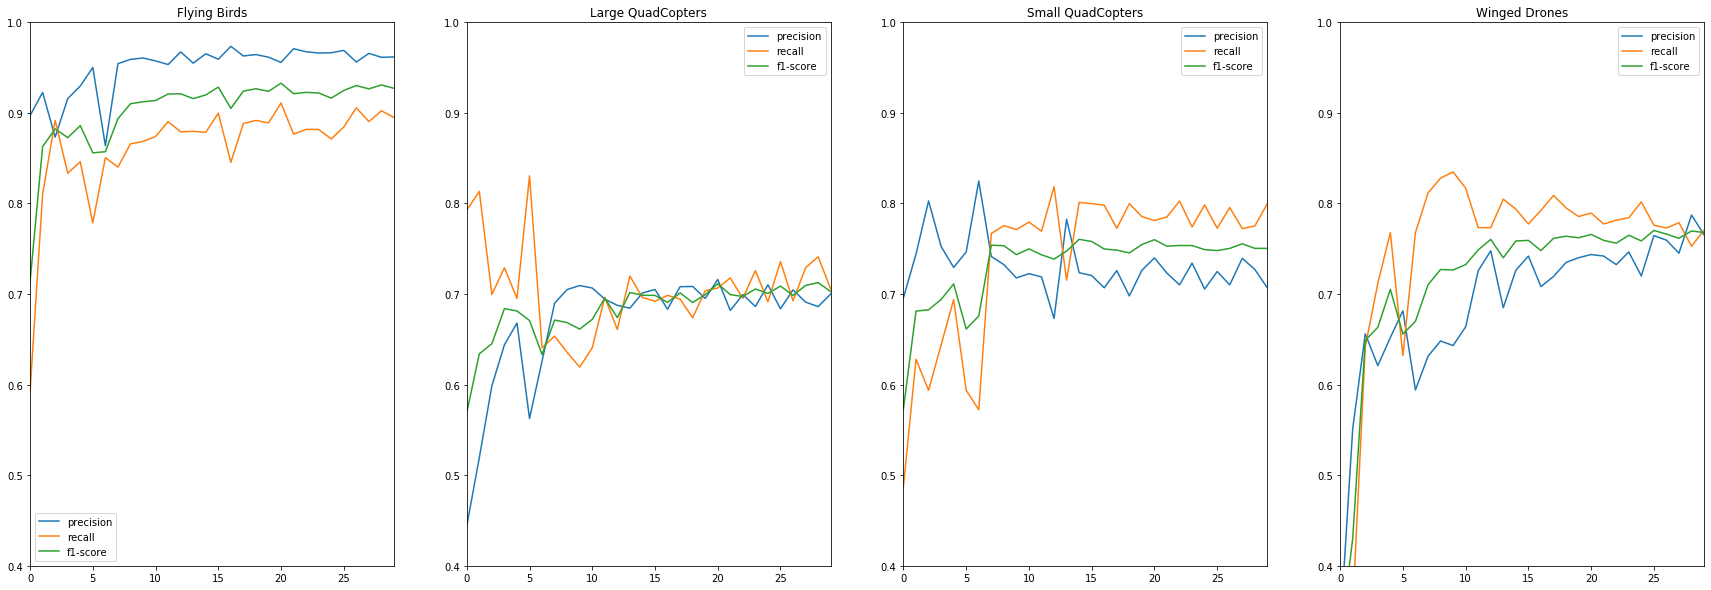

In [164]:
log_df = pd.read_json(log_file)['test'].apply(pd.Series)
dfs = [log_df['report'].apply(pd.Series)[str(cls_idx)].apply(pd.Series) for cls_idx in range(4)]

plt.figure(figsize=(30, 10))
for i, df in enumerate(dfs):
    ax = plt.subplot(1, len(dfs), i + 1)
    ax.set_ylim([0.4, 1])
    ax.set_title(dataset.mapper[i])
    df[['precision', 'recall', 'f1-score']].plot(ax=ax)

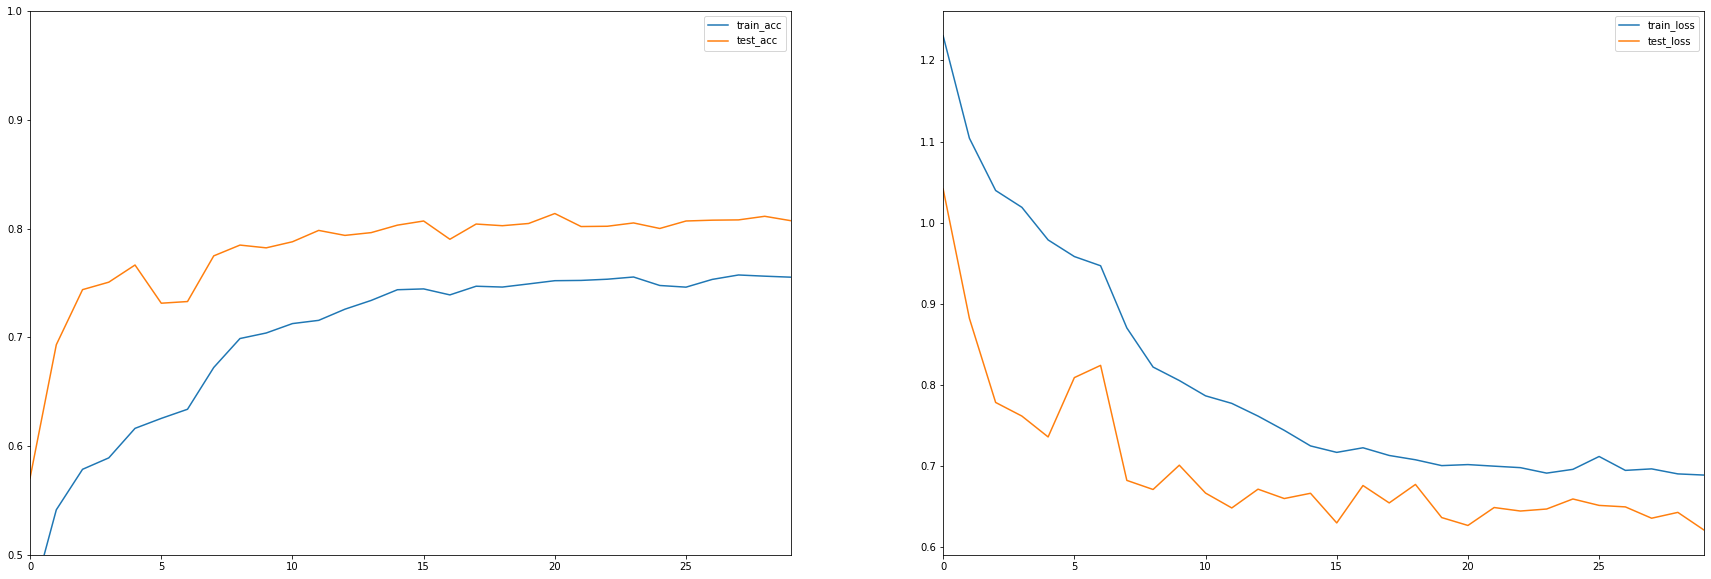

In [165]:
log_df = pd.read_json(log_file)['test'].apply(pd.Series)
test_acc = log_df['report'].apply(pd.Series)['accuracy']
test_loss = log_df['test_loss']

log_df = pd.read_json(log_file)['train'].apply(pd.Series)
train_acc = log_df['report'].apply(pd.Series)['accuracy']
train_loss = log_df['train_loss']

plt.figure(figsize=(30, 10))
ax = plt.subplot(1, 2, 1)
ax.set_ylim([0.5, 1])
pd.DataFrame({'train_acc': train_acc, 'test_acc': test_acc}).plot(ax=ax)

ax = plt.subplot(1, 2, 2)
pd.DataFrame({'train_loss': train_loss, 'test_loss': test_loss}).plot(ax=ax)